# Basic Info

## Team 1

- Ted Hsu ([thhsu4@illinois.edu](mailto:thhsu4@illinois.edu))
- Myles Iribarne ([mylesai2@illinois.edu](mailto:mylesai2@illinois.edu))
- Daniel Xu ([dhxu2@illinois.edu](mailto:dhxu2@illinois.edu))

## Paper

Our paper is _Transfer learning for ECG classification_ by Weimann and Conrad [1]. The project code is available on Github [2].

## Repo

The repo with our code is available on [Github](https://github.com/myles-i/DLH_TransferLearning/tree/master). Specifically, the reports are located [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/report).

# Introduction
## Background of the problem

- **What type of problem**:

  The problem is to classify Atrial Fibrillation (AF) on electrocardiogram (ECG) recordings.
- **What is the importance/meaning of solving the problem**:

  - A solution to the problem is a tool that will assist physicians in analyzing large amounts of patient ECG data in an automated and time efficient manner.
  - Early detection of AF events may lead to better patient outcomes.
  
- **What is the difficulty of the problem**:

  - Devices for recording patient ECG data are able to output a _huge_ amount of raw data. This is challenging and expensive to annotate for effective Deep Learning training.
  - Large class imbalance due to cardiovascular events of interests being rare.
  - Low ECG signal quality due to sampling frequency, single ECG lead probe.

- **The state of the art methods**:

  - Transfer learning using 1-D residual networks [3]
  - Representation learning using encoder-decoder architectures
    - Stacked Denoising AEs [4]
    - Seq2Seq model [5]

## Paper Explanation
- **What did the paper propose**:

  - Use Transfer learning to build better ECG classifiers.
  - Pre-train 1-D CNNs on the largest publicly available ECG dataset (_Icentia11K_) on several pre-training tasks:
    - Beat Classification
    - Rhythm Classifcation
    - Heart Rate Classification
    - Future Prediction
  - Finetune the pre-trained 1-D CNNs on a _different_ task and a _different_ dataset (_PhysioNet/CinC Challenge 2017_): classify AF events.

- **What is/are the innovations of the method**:

  - Demonstration of successful large-scale pre-training of 1-D CNNs on the largest publicly available ECG dataset to date.
  - Demonstration of contrastive pre-training (unsupervised representation learning) improving 1-D CNN performance on target task.
  - Novel usage of heart rate classification task for pre-training. Note that in this task, the labels can be automatically generated without manual intervention.

- **How well the proposed method work (in its own metrics)**:

  - The paper provides AF classifier performnace comparison among five different pre-training tasks configurations (Random initalization, Beat classification, Rhythm classification, Heart Rate classification, and Future Prediction). _Macro F1 score of the AF classifier on the Physionet test set is the performance metric._
  - The average macro F1 score of random initalization pre-training task is 0.731 over 10 trials. Average macro F1 scores reported by all proposed four pre-training tasks configurations range from 0.758 to 0.779 over 10 trials.

- **What is the contribution to the research regime (referring the Background above, how important the paper is to the problem)**:

  - Pre-training the 1-D CNN model improves the performance on the target task (i.e. AF classification), effectively reducing the number of labeled data required to achieve the same performance as 1-D CNNs that are not pre-trained.
  - Unsupervised pre-training (i.e. future prediction) on ECG data is a viable method for improving the performance on the target task and will become more relevant, since labeling ECG data is expensive.

# Scope of Reproducibility

## Hypothesis 1
Pre-training 1-D CNN models with an extremely large dataset of relatively inexpensively labeled data can improve performance of classification based on a smaller set of labeled data with a different classification objective (i.e. AF).

## Hypothesis 2
The paper does not explore how significant the effects of the pre-training data size are on the final results. We assume size of the pre-training dataset could affect the performance of the target task (i.e. AF classification).


## Verification
We will verify the hypotheses by attempting to reproduce results for a specific model and the following hyperparameter combination with 10% and 20% of the pre-training data used in the paper:

- Model: 1-D ResNet-18v2
- Pre-training Objective: Beat Classification
- Frame Size: 4096 samples
- Sample Rate: 250 Hz
- Fine-tuning objective: Atrial Fibrillation

Note that the data is at patient level, so the 10% and 20% will be applied to the total number of patients.

The results will be compared with the performance of a randomly initialized ResNet-18v2.

## Implementation

The paper authors have provided their code online on Github. In our repo, we have forked their code and made small adjustments for convenience in our reproduction work. The code cells below will import modules from the paper authors' code. In this way, we are able to focus primarily on executing the experiments and analyzing the outcomes.

# Ablation (Hypothesis 3)
The original paper is entirely based on 1-D CNNs and the raw ECG signal. To extend the paper's results, we aim to pre-process the raw signals using Fourier transforms to represent the data as a spectogram -- a frequency versus time representation of ECG signals.

Using this representation of the input, we will train a 2-D CNN model (i.e. 2-D ResNet-18v2) and compare the performance of pre-trained and randomly initialized models. Additionally, we will compare the 2-D model performance to the 1-D models originally used by the authors.

This extension is motivated by a study on ECG Arrhythmia classification that demonstrates the effectiveness of CNNs trained on spectrograms.[6] By converting ECG data to spectrogram features and then using spectrograms to pre-train a 2-D ResNet, we intend to illustrate the adaptability of the transfer learning framework in the original paper across diverse model architectures.


# Methodology

## Environment

First, we assume that this notebook is run in **Google Colab**. It is highly recommended to have Colab Pro and select **V100** GPU or better.

Below we prepare the environment with which the code in this notebook can run. Specifically, we clone the project repo which contains the paper's code and our modifications and install the project dependencies.

In [1]:
%%capture
REPO = '/tmp/repo'
! git clone https://github.com/myles-i/DLH_TransferLearning.git $REPO
%cd $REPO

Below we install all of the python dependencies. This is an addition we have made to the repository for ease of use. There is also a environment.yml file for use with conda

In [2]:
%%time
%%capture
!pip install -r requirements.txt

CPU times: user 83.8 ms, sys: 13.7 ms, total: 97.4 ms
Wall time: 14.3 s


In [3]:
# Prepare local directories
JOB_DIR = '/tmp/jobs'
DATA_DIR = '/tmp/data'
DEMO_DATA_DIR = DATA_DIR + '/draft_demo'

##  Data

### Pre-training Dataset
The training data is the "Icentia11k Single Lead Continuous Raw Electrocardiogram Dataset," which is freely available online.

- Source of the data
  - https://physionet.org/content/icentia11k-continuous-ecg/1.0/ (raw)
  - https://academictorrents.com/details/af04abfe9a3c96b30e5dd029eb185e19a7055272 (compressed)
- Statistics
  - 11,000 patients
  - Each patient has up to two weeks of ECG recordings with 250 Hz sampling rate.
  - Each ECG recording is accompanied with beat and rhythm labels marked by the ECG signal collection device and specialists, respectively.
  - Both beat and rhythm labels are assigned to positions in the signal at irregular intervals.
  - The original paper uses 95% of the patients for pre-training and the remaining 5% for validation.
- Data downloading:
  - We utilize the compressed data files rather than the raw files.
  - The process is demonstrated in [this notebook](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/Download_Icentia11k_Data.ipynb), which uses the `libtorrent` library to download the compressed version of the data from academictorrents.com.
  - The compressed data files are saved to an appropriately named sub-directory within the shared Google Drive directory `DATA_DIR`.





For beat classification pre-training, the each training data sample is generated by extracting a segment of continuous ECG signal that is associated with a beat label. Following is an example code to generate a training data sample from patient#0 with ECG signal frame size 2048:

In [4]:
# first download patient#0 ECG signal and labels
!mkdir -p $DEMO_DATA_DIR

%cd $DEMO_DATA_DIR

!gdown 1hzq0iSICypZTIrJcyPfAR5mPrKS1Vev_  # patient#0 ECG signal
!gdown 1vjBhJ_0w-bTn7jhnRPS3Bf3CsLpi7RuN  # patient#0 label

%cd $REPO

/tmp/data/draft_demo
Downloading...
From (original): https://drive.google.com/uc?id=1hzq0iSICypZTIrJcyPfAR5mPrKS1Vev_
From (redirected): https://drive.google.com/uc?id=1hzq0iSICypZTIrJcyPfAR5mPrKS1Vev_&confirm=t&uuid=e6af7a89-e6a6-4db0-8106-fadea44d6771
To: /tmp/data/draft_demo/00000_batched.npy
100% 210M/210M [00:00<00:00, 224MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vjBhJ_0w-bTn7jhnRPS3Bf3CsLpi7RuN
To: /tmp/data/draft_demo/00000_batched_lbls.npz
100% 6.79M/6.79M [00:00<00:00, 249MB/s]
/tmp/repo


In [5]:
from pretraining import datasets

gen = datasets.beat_generator(
    DEMO_DATA_DIR,
    patient_ids=[0],
    frame_size=4096,
    normalize=True,
    unzipped=True,
    samples_per_patient=1
)
data = next(gen)

Each sample is a tuple of ECG signal and beat label

beat label: normal


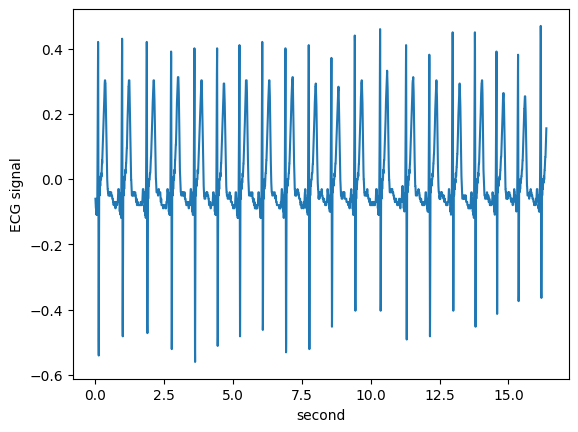

In [6]:
from matplotlib import pyplot as plt
import numpy as np

print(f"beat label: {datasets.icentia11k.ds_beat_names[data[1]]}")
_ = plt.plot(np.arange(len(data[0]))/250, data[0])
_ = plt.xlabel('second')
_ = plt.ylabel('ECG signal')

The `beat_generator` is used to create a `tensorflow` `Dataset` object. The following code creates a `Dataset` that contains 2048 training data samples from patient#0, each training data sample with frame size 2048.

In [7]:
dataset = datasets.beat_dataset(
    db_dir=DEMO_DATA_DIR, patient_ids=[0], frame_size=2048,
    unzipped=True, samples_per_patient=2048)
dataset.element_spec

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


(TensorSpec(shape=(2048, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

### Fine-tuning Dataset
The fine-tuning dataset is the "AF Classification from a Short Single Lead ECG Recording: The PhysioNet/Computing in Cardiology Challenge 2017" and freely available online for download.

- Source of the data
  - https://physionet.org/content/challenge-2017/1.0.0/
- Statistics
  - 8528 short ECG recordings.
  - Each ECG recording duration is 9 to 60 seconds with 300 Hz sampling rate.
  - Each ECG recording is labeled with one of the following classes: AF, Normal, Other or Noise (too noisy to classify).
- Data Downloading
  - The `train2017.zip` file needs to be extracted somewhere.
  - The files within need to be extracted and then preprocessed.
  - Preprocessing involves:
    - Resampling to 250 Hz to match the sample rate of the pre-training dataset.
    - Padding records to 65 seconds.
    - Standardizing the data using mean and standard deviation computed on the entire dataset.
  - A demo notebook showing the process can be found [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/finetune_working_demo.ipynb).
    - In the final report we may consider merging the demo notebook contents.

## Model used by authors
In this project, the CNN model of choice is ResNet-18v2. The 1-D ResNet-18v2 implemented in the paper's Github [2] is used to reproduce the paper's result.

We show how to use paper author's code to create a 1-D ResNet-18v2 for beat classification in pre-training.

### 1-D ResNet-18v2

* Model architecture
  * 18 layers
  * Input layer consists of convolution layer with 64 filters, kernel size=3 and stride=2. The output of the convolution layer passes through batch norm, ReLu and maxpooling layers sequentially.
  * Output layer is a classifier consisting of a densely-connected layer followed by softmax function.
  * The middle 16 layers consist of 8 residual blocks. A residual block consists of the following two components and outputs the sum of the two components' outputs.
    1. Two convolution layers, each followed by batch norm and ReLu.
    2. A shortcut that passes the input through a convolution layer followed by batch norm.
  * Configurations of the residual blocks
    * 1st and 2nd: 64 filters, kernel size=7, strides=2 and 1, respectively
    * 3rd and 4th: 128 filters, kernel size=5, strides=2 and 1, respectively
    * 5th and 6th: 256 filters, kernel size=5, strides=2 and 1, respectively
    * 7th and 8th: 512 filters, kernel size=3, strides=2 and 1, respectively
  * Detail [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/modules/resnet1d.py).
* Pre-training objectives
  * Loss function: [Sparse Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
    * `from_logits=True`
    * All other parameters are set to their default values.
  * Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * `beta_1`: 0.9
    * `beta_2`: 0.98
    * All other parameters are set to their default values.
  * Metric: [Sparse Categorical Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy)
* Fine-tuning objectives
  * Loss function: [Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
    * All parameters are set to their default values.
  * Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * All other parameters are set to their default values.
  * Metrics:
    * [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy)
    * Macro F1. See our `my_f1()` below.

### Pre-training 1-D ResNet-18v2 demo
Below we construct the pre-training ResNet-18v2 and show its structure.


In [8]:
import tensorflow as tf

from transplant.modules.resnet1d import ResNet
from transplant.datasets import icentia11k
from transplant.modules.utils import build_input_tensor_from_shape


resnet = ResNet(
    num_outputs=None,
    blocks=(2, 2, 2, 2),
    kernel_size=(7, 5, 5, 3),
    include_top=False
)

feature_extractor = tf.keras.Sequential([
    resnet,
    tf.keras.layers.GlobalAveragePooling1D()
])

num_classes = len(icentia11k.ds_beat_names)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])

# compiling model with optimizer, loss function and validation metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

# initialize the weights of the model
train_data = dataset.batch(32)
input_shape, _ = tf.compat.v1.data.get_output_shapes(train_data)
input_dtype, _ = tf.compat.v1.data.get_output_types(train_data)
inputs = build_input_tensor_from_shape(
    input_shape,
    dtype=input_dtype,
    ignore_batch_dim=True
)
model(inputs)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512)               4492480   
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 4495045 (17.15 MB)
Trainable params: 4485445 (17.11 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


### Fine-tuning 1-D ResNet-18v2 demo

TODO: This is a work in progress, will be in the final report.

## Training

### Computational Requirements

For the full pre-training and fine-tuning process, we use Google Colab Pro, V100 GPU (16 GB RAM).

<ins>Pretraining</ins>

During pretraining, we chose a batch size of 512 to fully utilize the 16GB of RAM on the V100 GPU. However, our training rate has been limited by not by the GPU speed, but the I/O time required to load/unzip the data files from disc. Experimenting with using A100 GPUs which has more ram (i.e. larger batch size) and is generally faster, we were unable to get significant speed improvements to justify the extra hourly cost of this GPU.

With a frame size of 4096, loading 4096 samples per patient and a batch size of 512, training on 2048 patient data (about 20%) took 2 hours and 30 minutes. During this time, we saved 16 checkpoints to be able to study how finetuning on different amounts of pre-training affects the final model's performance after finetuning

<ins>Finetuning</ins>

Unlike pre-training, we did not experience I/O overhead during training as the processed PhysioNet train and test data were able to fit into RAM.

We ran the entrypoint with 200 epochs but observed early stopping before 75 epochs in both pre-trained network and random network scenarios.

We observed that fine-tuning took between 21 to 22 seconds per epoch on average. Fine-tuning usually completed within 30 minutes on V100 GPUs.

### Implementation code
For beat classification pre-training, a checkpoint function is created to monitor training loss and save model weights of each epoch. Following demonstrate training with a small dataset. Note that model weights of each epoch are saved for fine tuning model initialization. Note that in keras and the way the author's implemented the pre-training step, 1 epoch is defined by batch size and steps-per-epoch (it does not imply training on the entire dataset once).

In [9]:
DRAFT_DEMO_JOB = JOB_DIR + '/draft_demo'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(DRAFT_DEMO_JOB + '/epoch_{epoch:02d}' + '/model.weights'),
    monitor='loss',
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    verbose=1
)

model.fit(
    train_data,
    steps_per_epoch=64,
    verbose=2,
    epochs=2,
    validation_data=None,
    callbacks=[checkpoint]
)

Epoch 1/2

Epoch 1: saving model to /tmp/jobs/draft_demo/epoch_01/model.weights
64/64 - 16s - loss: 0.2106 - acc: 0.9463 - 16s/epoch - 258ms/step
Epoch 2/2

Epoch 2: saving model to /tmp/jobs/draft_demo/epoch_02/model.weights
64/64 - 2s - loss: 0.0649 - acc: 0.9810 - 2s/epoch - 29ms/step


### Training through command line API
For both pre-training and fine-tuning, the paper author provides entrypoint scripts to run the entire process with parameters of choice. The following is the high level description of how the scripts work.

#### Pre-training

The source code from the paper authors can be found [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/pretraining).

1. Create train/validate data generator based on patient id and the number of samples per patient, both specified when calling the entrypoint.
2. A model is generated based on the model architectrue and pre-training task specified by the user.
3. Weights of the model are initialized. They can also be loaded from a weights file. For all pre-training in the project, we don't load weights.
4. Checkpoint function is created based on training metric. For pre-training, we use `loss` as training metric.
5. The model fits the train data. At the end of each training epoch, the checkpoint function is called for evaluation and save the model weights.

The paper uses 95% of the patient's ECG data. On average, the paper sample 4096 ECG frames per patient, which amounts to 42.8 million (11000x0.95x4096) training samples over the course of pre-training. For pre-training with 20% of the data used in paper, we use ECG data from 2048 patients and sample 4096 ECG frames per patient, resulting to roughly 8.4 million (2048x4096) training samples.

The following sample command calls the pre-training entrypoint to run pre-training with 20% of the data used in the paper.

* The command is easily adapted to run pre-training with 10% of the data in the paper.

```bash
!time python -m pretraining.trainer \
--job-dir "jobs/beat_classification_16epochs_to_20percent" \
--task "beat" \
--train $TRAIN_DATASET \
--arch "resnet18" \
--epochs 16 \
--patient-ids `seq 0 2047 | paste -sd, -` \
--steps-per-epoch 1024 \
--samples-per-patient 4096 \
--batch-size 512 \
--frame-size 4096
```

Explanation of the less obvious parameters:

* `--job-dir`: Output directory, where check points and weights are saved.

* `--task`: Pre-training task, `beat` for Beat classification.

* `--patient-ids`: Patient id(s) whose ECG data to be used in pre-training.

  * Multiple patients can be specified by passing a space separated sequence of ids.

* `--frame-size`: Number of ECG samples, with 250Hz sampling rate, in a ECG frame.

To use all data: number of patients x samples_per_patient = epochs x batch_size x steps-per-epoch.

For demonstration, we run the script in a much smaller scale below:

In [10]:
PRETRAIN_JOB_DIR = DRAFT_DEMO_JOB + '/pretraining'

In [11]:
%%time
!python -m pretraining.trainer \
--job-dir $PRETRAIN_JOB_DIR \
--task "beat" \
--train $DEMO_DATA_DIR \
--arch "resnet18" \
--epochs 2 \
--patient-ids 0 \
--steps-per-epoch 8 \
--samples-per-patient 4096 \
--batch-size 256 \
--frame-size 1024 \
--unzipped True \
--seed 2024

2024-04-15 01:24:06.083853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 01:24:06.083900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 01:24:06.085042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 01:24:07.100942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/jobs/draft_demo/pretraining
Setting random state 2024
Building train data generators
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
2024-04-1


#### Fine-tuning

The source code from the paper authors can be found [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/finetuning).

1. Train and test data set are already separated from the PhysioNet 2017 dataset, with a 80%/20% split, and are passed to the entrypoint. The validation dataset will be further separated from the train dataset based on user input.
2. A CNN model is generated based on the model architectrue specified by the user. Its output layer is fully connected with softmax activation.
3. Weights of the model are initialized. They can also be loaded from a weights file.
4. Checkpoint function is created based on validation metric. For fine-tuning, we use `f1` as the metric.
5. The model fits the train data. At the end of each training epoch, the checkpoint function is called for evaluation and saves the model weights with best macro F1 score on the validation set. Note that the model also is setup to end training early if the validation accuracy does not improve after 50 epochs.
6. The model is evaluated on the test set and the predicted probabilities are saved to a csv file.


The following sample command calls the fine-tuning entrypoint to run fine-tuning with random initialization.

```bash
python -m finetuning.trainer \
--job-dir $JOB_DIR \
--train $FINETUNE_TRAIN \
--test $FINETUNE_TEST \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 200 \
--seed 2024 \
--verbose
```

Explanation of the less obvious parameters:

* `--job-dir`: Output directory, where checkpoints and weights are saved.
* `--val-size`: This is the percentage of the train set size to set aside for the validation set.
  * Note that the PhysioNet data was already split into 80% train, 20% test. The paper uses 5% of the full dataset for validation.
  * Math: $6.25\% * 80\% = 5\%$
* `--val-metric`: Metric to evaluate the model at the end of each epoch on the validation dataset.
* `--seed`: Random state used to split the train into smaller train and validation.

Below is a small scale demonstration of fine-tuning with random weight initialization. We first download fine-tuning train and test datasets.

In [12]:
%%capture
%cd $DEMO_DATA_DIR

!gdown 10PVz1nmMaeIgxQ4sqDUeZlzhFVHOth5I  # train
!gdown 10FKjncGOZD6_BBCBbvpBQbWvfCLj88MC  # test

%cd $REPO

In [13]:
FINETUNE_TRAIN = DEMO_DATA_DIR + '/physionet_train.pkl'
FINETUNE_TEST = DEMO_DATA_DIR + '/physionet_test.pkl'
FINETUNE_JOB_DIR = DRAFT_DEMO_JOB + '/finetuning_random'

In [14]:
%%time
!python -m finetuning.trainer \
--job-dir FINETUNE_JOB_DIR \
--train $FINETUNE_TRAIN \
--test $FINETUNE_TEST \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 2 \
--seed 2024 \
--verbose

2024-04-15 01:24:50.193872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 01:24:50.193919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 01:24:50.195047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 01:24:51.167684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in FINETUNE_JOB_DIR
Setting random state 2024
Loading train data from /tmp/data/draft_demo/physionet_train.pkl ...
Split data into train 93.74% and validation 6.26%
Loading test data from /tmp/data/draft_demo/physi

The following sample command uses the fine-tuning entrypoint to run fine-tuning with pre-training weights.
```bash
python -m finetuning.trainer \
--job-dir $JOB_DIR \
--train $FINETUNE_TRAIN \
--test $FINETUNE_TEST \
--weights-file $WEIGHTS_FILE \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 200 \
--seed 2024 \
--verbose
```

Largely the same command as the previous for fine-tuning a randomly initialized network. But with this addition.

* `--weights-file $WEIGHTS_FILE`: Path to pre-trained weights or a checkpoint of the model to be used for model initialization.

Small scale demonstration below. We first download model weights from our experiments.

In [15]:
%%time
%%capture
!mkdir -p $JOB_DIR/finetune_baseline_65sec
!gdown 1Tl5CVIDoKFo37Q1FUwCVDqqb84lp-rRk \
    -O $DATA_DIR/finetune_baseline_65sec \--folder

!mkdir -p $JOB_DIR/finetune_pretrain_20_weights_65sec
!gdown 1-A0AqZe9sanj-8MZnoX4TUAYWrgcUTlg \
    -O $DATA_DIR/finetune_pretrain_20_weights_65sec --folder

!mkdir -p $JOB_DIR/finetune_pretrain_10_weights_65sec
!gdown 1-363P8B28RZIBwwFVhDvB7suE3nasnji \
    -O $DATA_DIR/finetune_pretrain_10_weights_65sec --folder

CPU times: user 232 ms, sys: 44.1 ms, total: 276 ms
Wall time: 40.7 s


In [16]:
WEIGHTS_FILE = DATA_DIR + '/finetune_pretrain_20_weights_65sec/best_model.weights'
FINETUNE_JOB_DIR = DRAFT_DEMO_JOB + '/finetuning_pretrained'

In [ ]:
%%time
!python -m finetuning.trainer \
--job-dir $FINETUNE_JOB_DIR \
--train $FINETUNE_TRAIN \
--test $FINETUNE_TEST \
--weights-file $WEIGHTS_FILE \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 2 \
--seed 2024 \
--verbose

2024-04-15 01:27:02.647404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 01:27:02.647456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 01:27:02.648765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 01:27:03.649451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/jobs/draft_demo/finetuning_pretrained
Setting random state 2024
Loading train data from /tmp/data/draft_demo/physionet_train.pkl ...
Split data into train 93.74% and validation 6.26%
Loading test data from 

# Ablation Study (Hypothesis 3)
For the ablation study, we are pre-processing the data to produce a spectogram for each ECG signal and then passing this result into a 2-D ResNet-18v2. Then, the same pre-training and fine-tuning process from the paper is followed. The goal is to test how extensible the papers ideas are to other models. The work-in-progress notebook that includes building the model in `keras`, the data pre-processing function, the `keras` data generators, and running two epochs of pre-training.

**Fine-tuning is not yet complete:**

Current progress is in this [notebook](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/explore_spectogram.ipynb).

Below, we explain the preprocessing and model in more detail:

### Ablation Preprocessing - spectogram
For the spectogram, the following parameters were chosen:

- window_size: 256 (~1 second)
- stride: 64 (~0.25 seconds)
- window type: hanning -> this is like a pre-defined convolution that isused to smooth the FFTs for each spectogram slice

After the spectogram for a data sample is computed, only the lower 32 frequency components (from 0-62.5 Hz) are selected to reduce the input size. This was chosen empirically and validated by reproducing the original signal with the filtered spectogram models.

The spectogram pre-processing and the data loaders for the pre-training can be found [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/datasets/icentia11k_spectogram.py).

Below, we show the raw ECG signal next to the spectogram of the same signal using our pre-processing function, and then use the spectogram pre-processor on the same ECG signal presented in the earlier "Data" section.


In [ ]:
from transplant.datasets.icentia11k_spectogram import spectogram_preprocessor
# use raw data we grabbed earlier

# first lets plot the raw signal for comparison
print(f"beat label: {datasets.icentia11k.ds_beat_names[data[1]]}")
_ = plt.plot(np.arange(len(data[0]))/250, data[0])
_ = plt.xlabel('second')
_ = plt.ylabel('ECG signal')


# now lets calculate and plot the spectogra of this raw signal
x = spectogram_preprocessor(data[0], frame_size = 4096)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im1 = ax.imshow(np.abs(x[:,:,0]), cmap='viridis', aspect='auto')
fig.colorbar(im1, label="Magnitude $|S_x(t, f)|$")
ax.set_title(f"Sample spectogram of shape {x.shape}")
ax.set_xlabel("Spectogram slice #")
ax.set_ylabel("Frequency Index")
ax.invert_yaxis()
plt.show()



### Ablation Model: 2-D ResNet-18v2
The model chosen for the ablation study using spectograms is similar to the original model used, but is a 2-D ResNet-18v2. It is presented here:

* Model architecture
  * 18 layers
  * Input layer consists of convolution layer with 64 filters, kernel size=7x7 and stride=2. The output of the convolution layer passes through batch norm, ReLu and maxpooling layer sequentially.
  * The middle 16 layers consists of 8 residual blocks. A residual block consists of the following two components and outputs the sum of the two components' outputs.
    1. Two convolution layers, each followed by batch norm and ReLu
    2. A shortcut that passes the input through a convolution layer followed by batch norm.
  * Output layer is a classifier consisting of a densely-connected layer followed by softmax or sigmoid function.
  * Configurations of the residual blocks
    * 1st and 2nd: 64 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 3rd and 4th: 128 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 5th and 6th: 256 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 7th and 8th: 512 filters, kernel size=3x3, strides=2 and 1, respectively.

* Pre-training objectives
  * The same as the original author's 1-D pre-training objectives.

* Fine-tuning objectives
  * The same as the original author's 1-D pre-training objectives (F1 score)

The code for the 2-D ResNet-18v2 can be found [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/modules/resnet2d.py).

This model is built and displayed below for reference:
  

In [ ]:
from transplant.modules.resnet2d import ResNet18_2D
import transplant.datasets.icentia11k as icentia11k

num_classes = len(icentia11k.ds_beat_names)
model = ResNet18_2D(num_classes=num_classes)
model.build(input_shape=(None, 64, 64, 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)
model.summary()

## Evaluation

### Metrics Descriptions

In fine-tuning, the paper uses macro F1 score for evaluating the model on the Physionet validation and test sets.

We define our macro F1 function `my_f1`. It is named like that because the paper authors define their F1 function named `f1` and we wish to avoid namespace collision. Additionally, our macro F1 function supports providing per-class F1 scores, which the paper authors do not support.


### Metrics Implementation code
See also analysis section for how we are using this metric in our results



In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def my_f1(y_true, y_prob, average='macro'):
    # set average=None to get per-class F1 scores.
    y_pred = y_prob >= np.max(y_prob, axis=1)[:, None]
    return f1_score(y_true, y_pred, average=average)

# Results
We used the pre-training entrypoint script and saved the model weights with 10% and 20% of the pre-training data used in paper. Then we ran the fine-tuning entrypoint script to perform fine-tuning and evaluate the model performance with random initilization and pre-training weights.


## Validation Macro F1 Comparison
We compare the macro F1 on the PhysioNet validation dataset over epoch between the model with random initialization weights and the model with pre-training weights.

This would be compared with Figure 3(a) in the paper.

Below we download for each model scenario the:
- Saved model weights.
- Training history containing validation macro F1 scores.
- Model predictions on the test set.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt


random_result = pd.read_csv(DATA_DIR + '/finetune_baseline_65sec/history.csv')
pretrain_20_result = pd.read_csv(
    DATA_DIR + '/finetune_pretrain_20_weights_65sec/history.csv'
)
pretrain_10_result = pd.read_csv(
    DATA_DIR + '/finetune_pretrain_10_weights_65sec/history.csv'
)

plt.plot(
    random_result['epoch'], random_result['f1'],
    color='tab:red', label='Random'
)
plt.plot(
    pretrain_20_result['epoch'], pretrain_20_result['f1'],
    color='tab:blue', label='Pre-train 20'
)
plt.plot(
    pretrain_10_result['epoch'], pretrain_10_result['f1'],
    color='tab:green', label='Pre-train 10'
)
plt.xlabel('Epoch')
plt.ylabel('Validation Macro F1')
ax = plt.gca()
ax.set_xlim([0, 80])
ax.set_ylim([0.5, 1.0])
_ = plt.legend(loc='upper right')

### Analysis
With pre-training weights, the F1 scores stabilize much sooner than random initialization. The model with pre-training weights also outperforms the random initalization model for the most part.

## Test Macro F1 Comparison


### Demonstration of obtaining test predictions
The fine-tuning entrypoint performs inference on the test set using the model with the highest validation macro F1 score, and saves the result to a CSV file.

It is this CSV file that we will perform macro F1 evaluation.

### Evaluating test predictions with macro F1

The CSV file contains model predicted probabilities for each of the four classes and the actual class label. We preview the CSV file for the randomly initialized model.

In [ ]:
random_preds = pd.read_csv(
    DATA_DIR + '/finetune_baseline_65sec/test_predictions.csv'
)
random_preds.head()

The paper authors provide a function to read the CSV and transform it into a format amenable to usage with `my_f1`. We make use of the function and show the macro F1 scores for each of the three scenarios.

In [ ]:
from transplant.utils import read_predictions

test_df_random = read_predictions(
    DATA_DIR + '/finetune_baseline_65sec/test_predictions.csv'
)
test_df_pretrain_10 = read_predictions(
    DATA_DIR + '/finetune_pretrain_10_weights_65sec/test_predictions.csv'
)
test_df_pretrain_20 = read_predictions(
    DATA_DIR + '/finetune_pretrain_20_weights_65sec/test_predictions.csv'
)

In [ ]:
def get_test_f1(formatted_predictions):
    # Convenience function to compute macro F1 score.
    y_true = formatted_predictions['y_true']
    y_prob = formatted_predictions['y_prob']
    return my_f1(y_true, y_prob)

In [ ]:
test_f1_scores = pd.DataFrame.from_dict(
    {
        'random': get_test_f1(test_df_random),
        'pretrain_10': get_test_f1(test_df_pretrain_10),
        'pretrain_20': get_test_f1(test_df_pretrain_20),
    },
    orient='index',
    columns=['Macro F1'],
).reset_index(names='Scenario')

test_f1_scores

## Planned work to complete this Project
The paper runs fine-tuning 10 times for each weights initialization method and then plots the F1 versus Epoch graph. So far, we have only run fine-tuning once for each of randomly initialized network and pre-trained network. We can run fine-tuning more times and then compare with Figure 3(a) in the paper again.

- Specifically, we need to set a different seed for each fine-tuning run, which we will be doing via the entrypoint.
- We need to run about 30 experiments in total, one each for the random, 20% pre-train data, and 10% pre-train data scenarios. Fortunately for us, this work is highly parallelizable.

We shall also work on the spectrogram ablation:

- Get pre-training to work.
- Define the setup (loss, optimizer, etc.) for the 2-D ResNet-18v2 for fine-tuning.
- Get fine-tuning to work.
- Compare random initialization performance to pre-trained performance
  - Validation macro F1.
  - Test macro F1.

# References

1. Weimann, K., Conrad, T.O.F. Transfer learning for ECG classification. Sci Rep 11, 5251 (2021). https://doi.org/10.1038/s41598-021-84374-8
2. https://github.com/kweimann/ecg-transfer-learning
3. M. Kachuee, S. Fazeli and M. Sarrafzadeh, "ECG Heartbeat Classification: A Deep Transferable Representation," 2018 IEEE International Conference on Healthcare Informatics (ICHI), New York, NY, USA, 2018, pp. 443-444, doi: 10.1109/ICHI.2018.00092.
4. Rahhal, M. A. et al. Deep learning approach for active classification of electrocardiogram signals. Inf. Sci. 345, 340–354. https:// doi.org/10.1016/j.ins.2016.01.082 (2016).
5. Rajan, D., Beymer, D., & Narayan, G. Generalization Studies of Neural Network Models for Cardiac Disease Detection Using Limited Channel ECG (2019). arXiv:1901.03295.
6. J. Huang, B. Chen, B. Yao and W. He, “ECG Arrhythmia Classification Using STFT-Based Spectrogram and Convolutional
 Neural Network,” in IEEE Access, vol. 7



In [ ]:
# Convert to html (to then be converted to pdf separately)
# !jupyter nbconvert --to html ../../content/DL4H_Team_1_draft.ipynb